# JOB-A-THON (NOVEMBER 21, ANALYTICS VIDHYA)

***This solution takes the following approach***

**1. Data Cleaning (ETL).**
    
   * Date type features (MM-YYYY, Date_of_Joining, Last_Working_Date) are converted to *datetime*.
    
   * Columns are renamed for better understanding and easy processing.

**2. Feature Extraction**
   
   * **Attrition ("Target")** is generated with the help of Last_Working_Date column If the employee has a Last working date (i.e., not Nan) then the Attrition 'Target' is considered as 1 else it is 0.
   
   * **"Promotion"** is generated with the help of designation related columns. Designation is substracted from Joining_Designation. 
    
   * **"Work_Period"** is generated with the help of date related columns. If the employee has not left the company then it is generated by substracting MM-YYYY from Date_of_Joining else by substracting Last_Working_Date from Date_of_Joining.

**3. Since the data contains multiple entries for same employee, the data is further cleaned and grouped to have a single row for each employee.**
    
   * The age, salary, total_business_value, quaterly_rating, and promotion are *averaged* over all entries for each employee.
   
   * For all the other columns the last/latest value is considered as the final value.

**4. Final Feature Egineering**
    
   * Unnecessary fearues are dropped (Emp_ID, Last_working_date, Date_of_Joining, designation, joining_designation, MM-YYYY)
   
   * Categorical features are **label encoded** (Gender, City, Education_Level)
    
**5. Separating Test and train data**
    
   * Test data is read from given dataset.
   
   * Test and Train sets are created.
    
**6. Modelling and validation**
    
   * *Multiple models (**baseline**)* are applied with a 3 fold cross-validation on the training set.
   
   * Best performing model is further taken to select the best Parameters with 3-fold **Sequential Feature Selection** approach.
   
   * Then with **best Parameters best Hyper-Parameters are selected** with 3-fold **Grid Search**.
   
   * Then again with best Hyper-Parameters Best Parameters are serched with 3-fold Sequential Feature Selection approach.

**7. Testing and submission**
    
   * Finally the model is applied to the test set.
   
   * The output of the test set is then submitted.

**P.S. Casual visualizations in form of graph and tables is done to visualize the data distribution.**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicting-employee-attrition/sample_submission_znWiLZ4.csv
/kaggle/input/predicting-employee-attrition/test_hXY9mYw.csv
/kaggle/input/predicting-employee-attrition/train_MpHjUjU.csv


# IMPORTING LIBRARIES

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# DEFINING THE MULTI-COLUMN LABEL ENCODER

In [3]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self 

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# READING THE DATASET


In [4]:
df = pd.read_csv("../input/predicting-employee-attrition/train_MpHjUjU.csv")
df.head()

,MMM-YY,Emp_ID,Age,Gender,City,Education_Level,Salary,Dateofjoining,LastWorkingDate,Joining Designation,Designation,Total Business Value,Quarterly Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaN,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaN,2,2,0,1


# VIEWING DATASET INFO

In [5]:
for i in df:
    print ('Variable:', i)
    print ('Count:', df[i].value_counts())
    print ('\n')
df.info()
    

Variable: MMM-YY
Count: 2016-01-01    1022
2016-02-01     944
2016-03-01     870
2017-12-01     819
2017-10-01     818
2017-08-01     812
2017-09-01     809
2017-07-01     806
2017-11-01     805
2016-12-01     795
2016-04-01     794
2017-01-01     782
2016-11-01     781
2017-06-01     770
2017-05-01     766
2016-05-01     764
2016-09-01     762
2017-02-01     761
2016-07-01     757
2016-08-01     754
2016-10-01     739
2017-04-01     729
2016-06-01     726
2017-03-01     719
Name: MMM-YY, dtype: int64


Variable: Emp_ID
Count: 2110    24
2617    24
1623    24
1642    24
1644    24
        ..
1614     1
445      1
2397     1
1619     1
469      1
Name: Emp_ID, Length: 2381, dtype: int64


Variable: Age
Count: 36    1283
33    1250
34    1234
32    1150
30    1146
35    1138
31    1090
29    1013
37     862
38     854
39     788
28     772
27     752
40     706
41     661
26     583
42     478
25     449
44     407
43     399
45     371
46     350
24     277
47     224
23     193
48     

# VISUALIZING THE DATASET

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


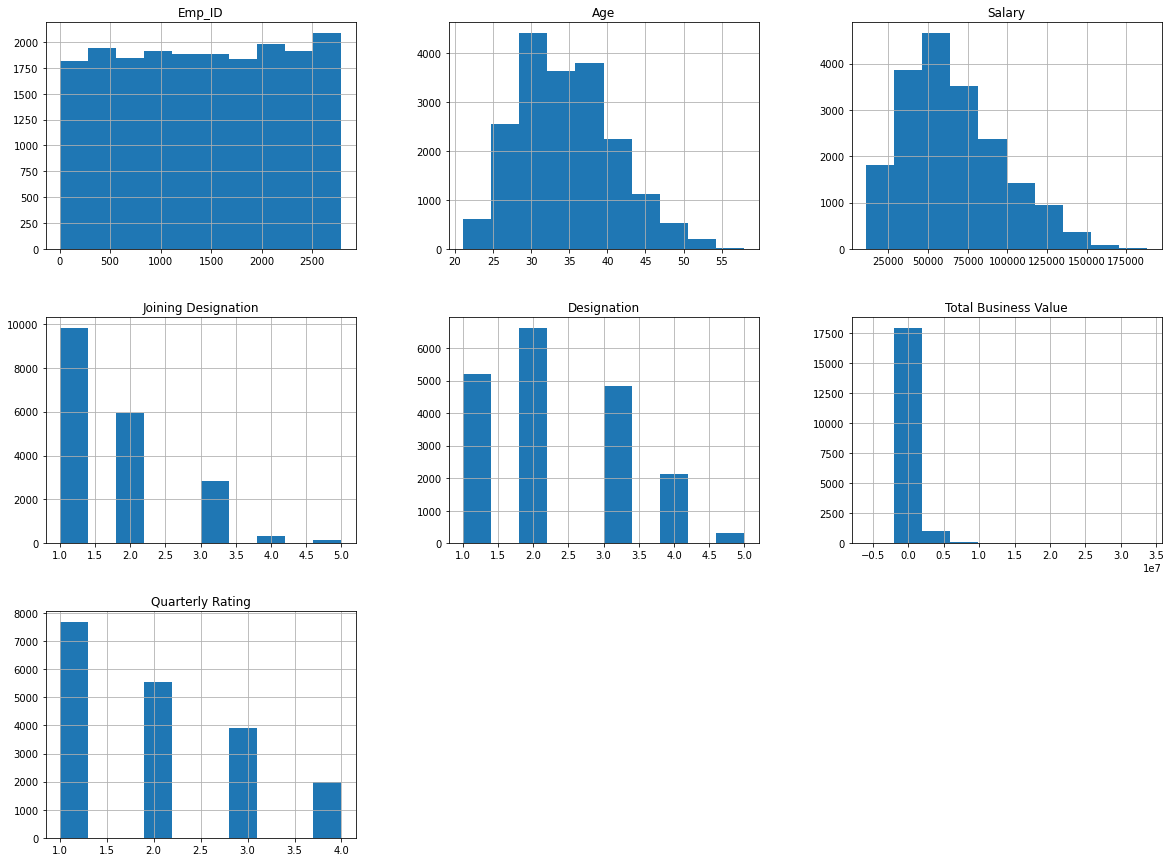

In [6]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

# CHANGING DATES DATA-TYPE

In [7]:
df['MMM-YY'] = pd.to_datetime(df['MMM-YY'])
df['Dateofjoining'] = pd.to_datetime(df['Dateofjoining'])
df['LastWorkingDate'] = pd.to_datetime(df['LastWorkingDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   MMM-YY                19104 non-null  datetime64[ns]
 1   Emp_ID                19104 non-null  int64         
 2   Age                   19104 non-null  int64         
 3   Gender                19104 non-null  object        
 4   City                  19104 non-null  object        
 5   Education_Level       19104 non-null  object        
 6   Salary                19104 non-null  int64         
 7   Dateofjoining         19104 non-null  datetime64[ns]
 8   LastWorkingDate       1616 non-null   datetime64[ns]
 9   Joining Designation   19104 non-null  int64         
 10  Designation           19104 non-null  int64         
 11  Total Business Value  19104 non-null  int64         
 12  Quarterly Rating      19104 non-null  int64         
dtypes: datetime64[ns

# RENAMING THE COLUMNS

In [8]:
df.columns
col = ['Month', 'Emp_ID', 'Age', 'Gender', 'City', 'Education_Level',
       'Salary', 'Date_of_Joining', 'Last_Working_Date', 'Joining_Designation',
       'Designation', 'Total_Business_Value', 'Quarterly_Rating']
df.columns = col 
df.head()

,Month,Emp_ID,Age,Gender,City,Education_Level,Salary,Date_of_Joining,Last_Working_Date,Joining_Designation,Designation,Total_Business_Value,Quarterly_Rating
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1


# CREATING **PROMOTION** FEATURE

In [9]:
df['Promotion'] = df['Designation'] - df['Joining_Designation']
df.head()

,Month,Emp_ID,Age,Gender,City,Education_Level,Salary,Date_of_Joining,Last_Working_Date,Joining_Designation,Designation,Total_Business_Value,Quarterly_Rating,Promotion
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,0
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,0
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,0
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,0


# CREATING **Work_Period** FEATURE

In [10]:
Work_Period = []
for i in range(len(df)):
    j = pd.isnull(df.iloc[i]['Last_Working_Date'])
    if j:
        wp = df.iloc[i]['Month'] - df.iloc[i]['Date_of_Joining']
        wp = wp.days
        wp = wp + 30
        Work_Period.append(wp)
    else:
        wp = df.iloc[i]['Last_Working_Date'] - df.iloc[i]['Date_of_Joining'] 
        wp = wp.days
        Work_Period.append(wp)
df['Work_Period'] = Work_Period
df.head()

,Month,Emp_ID,Age,Gender,City,Education_Level,Salary,Date_of_Joining,Last_Working_Date,Joining_Designation,Designation,Total_Business_Value,Quarterly_Rating,Promotion,Work_Period
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,0,38
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,0,69
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,0,78
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,0,25
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,0,55


# CREATING **TARGET** FEATURE

In [11]:
Target = []
for i in df.Last_Working_Date.isna():
    if i:
        Target.append(0)
    else:
        Target.append(1)
df['Target'] = Target
df.head()

,Month,Emp_ID,Age,Gender,City,Education_Level,Salary,Date_of_Joining,Last_Working_Date,Joining_Designation,Designation,Total_Business_Value,Quarterly_Rating,Promotion,Work_Period,Target
0,2016-01-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,2381060,2,0,38,0
1,2016-02-01,1,28,Male,C23,Master,57387,2015-12-24,NaT,1,1,-665480,2,0,69,0
2,2016-03-01,1,28,Male,C23,Master,57387,2015-12-24,2016-03-11,1,1,0,2,0,78,1
3,2017-11-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,0,25,0
4,2017-12-01,2,31,Male,C7,Master,67016,2017-11-06,NaT,2,2,0,1,0,55,0


# REMOVING REDUNDANT FEATURES

In [12]:
df1 = df.drop(columns = ['Designation', 'Joining_Designation', 'Last_Working_Date', 'Month', 'Date_of_Joining'])
print(df1.info())
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Emp_ID                19104 non-null  int64 
 1   Age                   19104 non-null  int64 
 2   Gender                19104 non-null  object
 3   City                  19104 non-null  object
 4   Education_Level       19104 non-null  object
 5   Salary                19104 non-null  int64 
 6   Total_Business_Value  19104 non-null  int64 
 7   Quarterly_Rating      19104 non-null  int64 
 8   Promotion             19104 non-null  int64 
 9   Work_Period           19104 non-null  int64 
 10  Target                19104 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 1.6+ MB
None


,Emp_ID,Age,Gender,City,Education_Level,Salary,Total_Business_Value,Quarterly_Rating,Promotion,Work_Period,Target
0,1,28,Male,C23,Master,57387,2381060,2,0,38,0
1,1,28,Male,C23,Master,57387,-665480,2,0,69,0
2,1,28,Male,C23,Master,57387,0,2,0,78,1
3,2,31,Male,C7,Master,67016,0,1,0,25,0
4,2,31,Male,C7,Master,67016,0,1,0,55,0


# VISUALIZING THE DATASET (WITH EXTRACTED FEATURES)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'Emp_ID'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Salary'}>],
       [<AxesSubplot:title={'center':'Total_Business_Value'}>,
        <AxesSubplot:title={'center':'Quarterly_Rating'}>,
        <AxesSubplot:title={'center':'Promotion'}>],
       [<AxesSubplot:title={'center':'Work_Period'}>,
        <AxesSubplot:title={'center':'Target'}>, <AxesSubplot:>]],
      dtype=object)

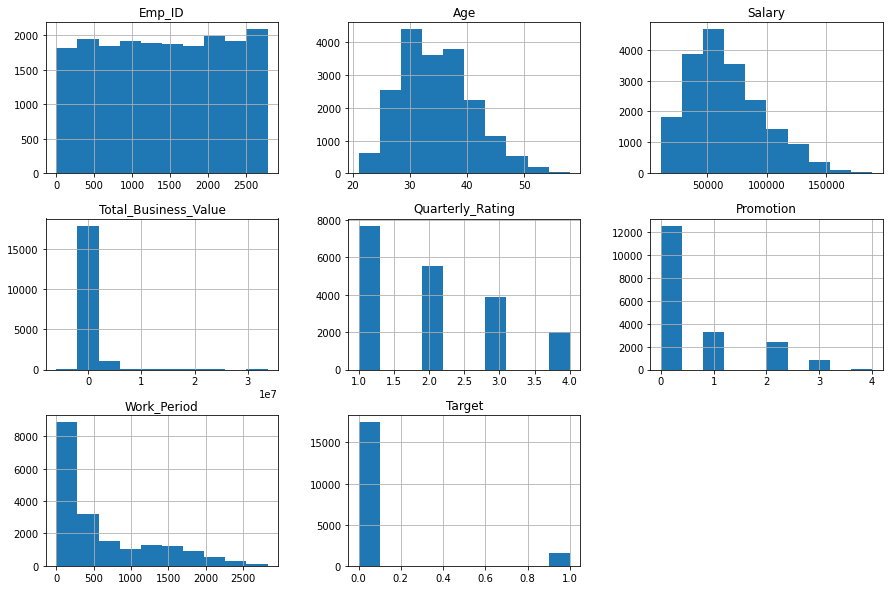

In [13]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
df1.hist(ax = ax)

# VIEWING DATASET INFO (WITH EXTRACTED FEATURES)

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19104 entries, 0 to 19103
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Emp_ID                19104 non-null  int64 
 1   Age                   19104 non-null  int64 
 2   Gender                19104 non-null  object
 3   City                  19104 non-null  object
 4   Education_Level       19104 non-null  object
 5   Salary                19104 non-null  int64 
 6   Total_Business_Value  19104 non-null  int64 
 7   Quarterly_Rating      19104 non-null  int64 
 8   Promotion             19104 non-null  int64 
 9   Work_Period           19104 non-null  int64 
 10  Target                19104 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 1.6+ MB


# REMOVING MULTIPLE ENTRIES FOR SAME EMPLOYEE (AVERAGING/MODIFYING THE VARIABLES)

In [15]:
b = []
j = 0
while (j < len(df1)):
    a = []
    eid = df1.iloc[j][0]
    age = df1.iloc[j][1]
    gen = df1.iloc[j][2]
    cit = df1.iloc[j][3]
    edl = df1.iloc[j][4]
    slr = df1.iloc[j][5]
    tbv = df1.iloc[j][6]
    qrt = df1.iloc[j][7]
    prm = df1.iloc[j][8]
    tar = df1.iloc[j][9]
    wpd = df1.iloc[j][10]
    i = j+1
    while (i>0 and i<len(df1)):
        if(df1.iloc[i][0] == df1.iloc[i-1][0]):
            if(df1.iloc[i][1] != df1.iloc[i-1][1]):
                age = (age + df1.iloc[i][1])/2
            if(df1.iloc[i][5] != df1.iloc[i-1][5]):
                slr = (slr + df1.iloc[i][5])/2
            if(df1.iloc[i][6] != df1.iloc[i-1][6]):
                tbv = (tbv + df1.iloc[i][6])/2
            if(df1.iloc[i][7] != df1.iloc[i-1][7]):
                qrt = (qrt + df1.iloc[i][7])/2
            if(df1.iloc[i][8] != df1.iloc[i-1][8]):
                prm = (prm + df1.iloc[i][8])/2
            if(df1.iloc[i][9] != df1.iloc[i-1][9]):
                tar = df1.iloc[i][9]
            if(df1.iloc[i][10] != df1.iloc[i-1][10]):
                wpd = df1.iloc[i][10]
        else:
            break
        i+=1
    a.append(eid)
    a.append(age)
    a.append(gen)
    a.append(cit)
    a.append(edl)
    a.append(slr)
    a.append(wpd)
    a.append(tbv)
    a.append(qrt)
    a.append(prm)
    a.append(tar)
    b.append(a)
    j = i
dfc = pd.DataFrame(b)
dfc.head()
        
    

,0,1,2,3,4,5,6,7,8,9,10
0,1,28.0,Male,C23,Master,57387.0,1,428895.0,2.0,0.0,78
1,2,31.0,Male,C7,Master,67016.0,0,0.0,1.0,0.0,55
2,4,43.0,Male,C13,Master,65603.0,1,87500.0,1.0,0.0,141
3,5,29.0,Male,C9,College,46368.0,1,30090.0,1.0,0.0,58
4,6,31.0,Female,C11,Bachelor,78728.0,0,316250.0,1.5,0.0,153


# RENAMING COLUMNS IN THE CLEANED DATASET

In [16]:
dfc.columns = ['Emp_ID', 'Average_Age', 'Gender', 'City', 'Education_Level', 'Average_Salary',
       'Work_Period', 'Average_Total_Business_Value', 'Average_Quarterly_Rating',
       'Average_Promotion', 'Target']
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Emp_ID                        2381 non-null   int64  
 1   Average_Age                   2381 non-null   float64
 2   Gender                        2381 non-null   object 
 3   City                          2381 non-null   object 
 4   Education_Level               2381 non-null   object 
 5   Average_Salary                2381 non-null   float64
 6   Work_Period                   2381 non-null   int64  
 7   Average_Total_Business_Value  2381 non-null   float64
 8   Average_Quarterly_Rating      2381 non-null   float64
 9   Average_Promotion             2381 non-null   float64
 10  Target                        2381 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 204.7+ KB


# VISUALISING THE CLEANED DATASET (WITH AVERAGED FEATURES)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'Emp_ID'}>,
        <AxesSubplot:title={'center':'Average_Age'}>,
        <AxesSubplot:title={'center':'Average_Salary'}>],
       [<AxesSubplot:title={'center':'Work_Period'}>,
        <AxesSubplot:title={'center':'Average_Total_Business_Value'}>,
        <AxesSubplot:title={'center':'Average_Quarterly_Rating'}>],
       [<AxesSubplot:title={'center':'Average_Promotion'}>,
        <AxesSubplot:title={'center':'Target'}>, <AxesSubplot:>]],
      dtype=object)

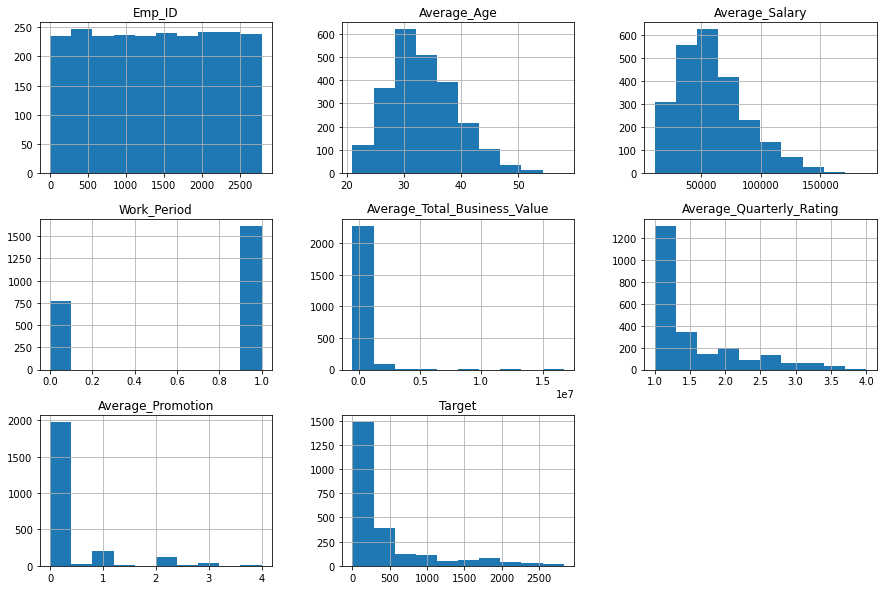

In [17]:
fig = plt.figure(figsize = (15,10))
ax = fig.gca()
dfc.hist(ax = ax)

# ENCODING THE CATEGORINGAL VARIABLES

In [18]:
dfc_encoded = MultiColumnLabelEncoder(columns = ['Gender','City', 'Education_Level']).fit_transform(dfc)
dfc_encoded.head()

,Emp_ID,Average_Age,Gender,City,Education_Level,Average_Salary,Work_Period,Average_Total_Business_Value,Average_Quarterly_Rating,Average_Promotion,Target
0,1,28.0,1,15,2,57387.0,1,428895.0,2.0,0.0,78
1,2,31.0,1,26,2,67016.0,0,0.0,1.0,0.0,55
2,4,43.0,1,4,2,65603.0,1,87500.0,1.0,0.0,141
3,5,29.0,1,28,1,46368.0,1,30090.0,1.0,0.0,58
4,6,31.0,0,2,0,78728.0,0,316250.0,1.5,0.0,153


# READING THE TEST FILE (GIVEN)

In [19]:
testf = pd.read_csv("../input/predicting-employee-attrition/test_hXY9mYw.csv")
testf.head()

,Emp_ID
0,394
1,173
2,1090
3,840
4,308


# SEPERATING TRAIN AND TEST SETS

In [20]:
test = dfc_encoded[dfc_encoded.Emp_ID.isin(testf.Emp_ID)]
train = dfc_encoded[~dfc_encoded.Emp_ID.isin(testf.Emp_ID)]
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1640 entries, 0 to 2379
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Emp_ID                        1640 non-null   int64  
 1   Average_Age                   1640 non-null   float64
 2   Gender                        1640 non-null   int64  
 3   City                          1640 non-null   int64  
 4   Education_Level               1640 non-null   int64  
 5   Average_Salary                1640 non-null   float64
 6   Work_Period                   1640 non-null   int64  
 7   Average_Total_Business_Value  1640 non-null   float64
 8   Average_Quarterly_Rating      1640 non-null   float64
 9   Average_Promotion             1640 non-null   float64
 10  Target                        1640 non-null   int64  
dtypes: float64(5), int64(6)
memory usage: 153.8 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 741 entries, 1 to 2

# VISUALIZING TRAINING DATA

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'Emp_ID'}>,
        <AxesSubplot:title={'center':'Average_Age'}>,
        <AxesSubplot:title={'center':'Gender'}>],
       [<AxesSubplot:title={'center':'City'}>,
        <AxesSubplot:title={'center':'Education_Level'}>,
        <AxesSubplot:title={'center':'Average_Salary'}>],
       [<AxesSubplot:title={'center':'Work_Period'}>,
        <AxesSubplot:title={'center':'Average_Total_Business_Value'}>,
        <AxesSubplot:title={'center':'Average_Quarterly_Rating'}>],
       [<AxesSubplot:title={'center':'Average_Promotion'}>,
        <AxesSubplot:title={'center':'Target'}>, <AxesSubplot:>]],
      dtype=object)

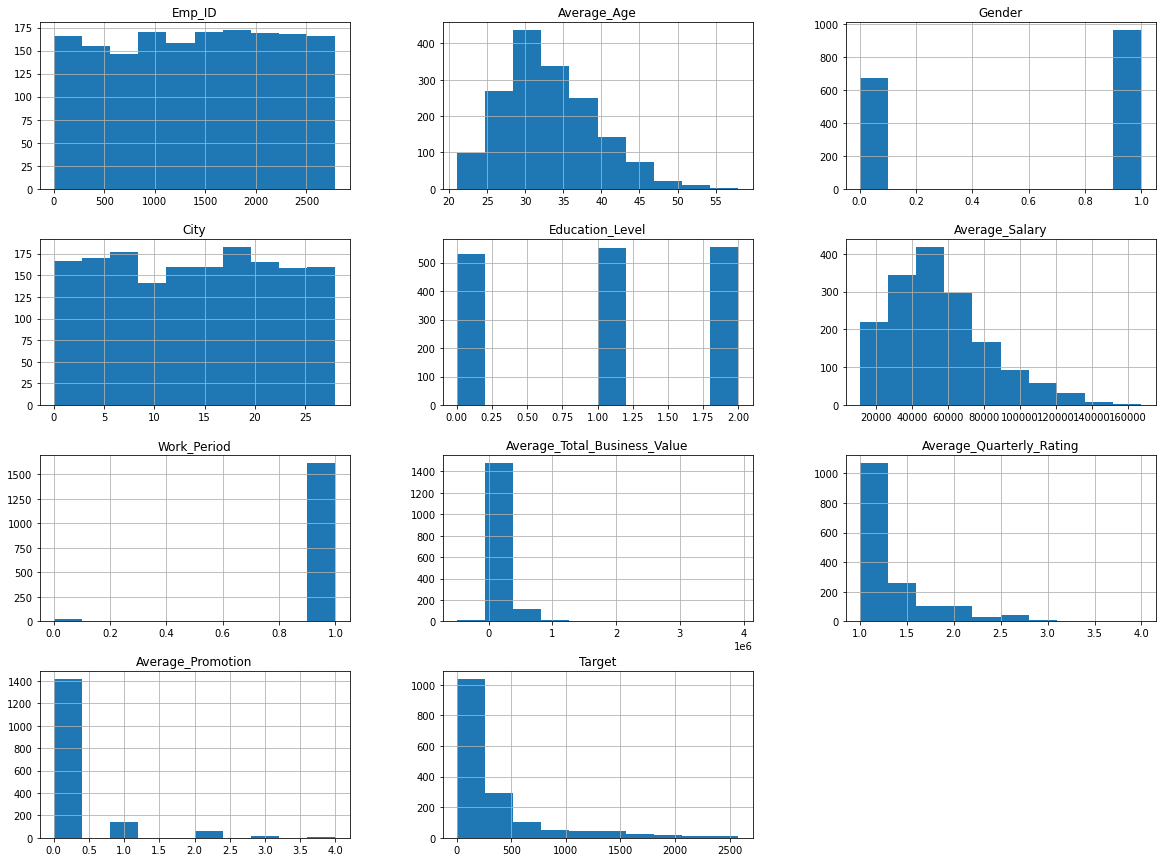

In [21]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
train.hist(ax = ax)

# VISUALIZING TEST DATA

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<AxesSubplot:title={'center':'Emp_ID'}>,
        <AxesSubplot:title={'center':'Average_Age'}>,
        <AxesSubplot:title={'center':'Gender'}>],
       [<AxesSubplot:title={'center':'City'}>,
        <AxesSubplot:title={'center':'Education_Level'}>,
        <AxesSubplot:title={'center':'Average_Salary'}>],
       [<AxesSubplot:title={'center':'Work_Period'}>,
        <AxesSubplot:title={'center':'Average_Total_Business_Value'}>,
        <AxesSubplot:title={'center':'Average_Quarterly_Rating'}>],
       [<AxesSubplot:title={'center':'Average_Promotion'}>,
        <AxesSubplot:title={'center':'Target'}>, <AxesSubplot:>]],
      dtype=object)

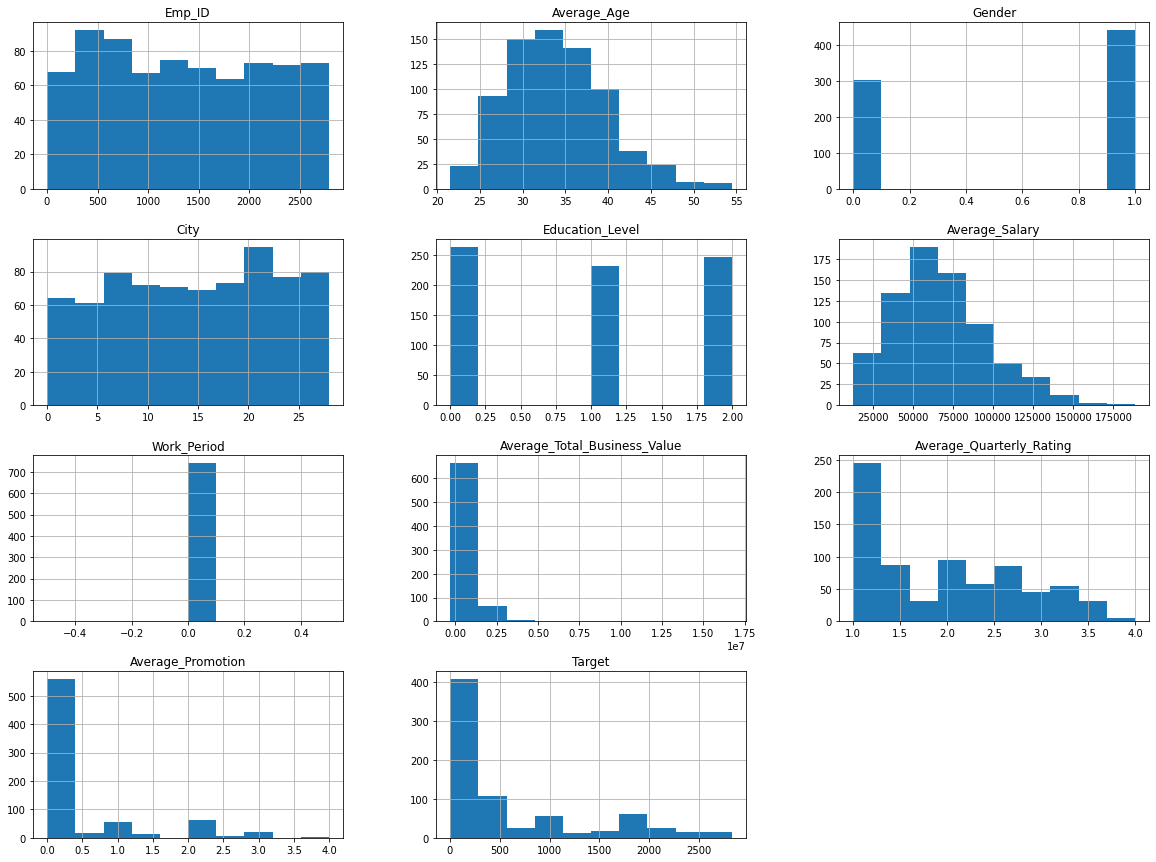

In [22]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
test.hist(ax = ax)

# DFINING X,y FOR MODELLING

In [23]:
X_train = train.drop(columns = ['Emp_ID', 'Target'])
y_train = train.Target
X_test = test.drop(columns = ['Emp_ID', 'Target'])
y_test = test.Target

# APPLYING BASELINE MODELS

In [24]:
models = []

models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))
models.append(("LinearSVC",LinearSVC()))
models.append(("NaiveBayes",GaussianNB()))
models.append(("LDA",LinearDiscriminantAnalysis()))
models.append(("QDA",QuadraticDiscriminantAnalysis()))
models.append(("KNeighbors",KNeighborsClassifier()))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
models.append(("AdaBoost",AdaBoostClassifier()))
models.append(("GradientBoost",GradientBoostingClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("NeuralNet",MLPClassifier()))


results = []
names = []
for name,model in models:
    kfold = StratifiedKFold(n_splits = 3, random_state = 1, shuffle = True)
    result = cross_val_score(model, X_train, y_train,  cv=kfold, scoring = 'f1')
    names.append(name)
    results.append(result)

for i in range(len(names)):
    print('%s: %f (%f)' % (names[i],results[i].mean(), results[i].std()))

fig = plt.figure(figsize = (20, 10))
ax = fig.add_subplot(111)
sns.boxplot(data = results)
ax.set(xlabel = 'Algorithms',
      ylabel = 'F1 Score')
ax.set_xticklabels(names)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1417, in fit
    for class_, warm_start_coef_ in zip(classes_, warm_start_coef))
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.p

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

Since most models have similar outputs, Neural Network is the best choice as it is flexible to train.

# TESTING THE BASELINE MODEL ON THE TEST SET

In [ ]:
model = MLPClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, labels = [0,1]))
